## Air Passengers Data

Goal is to predict the number of air passengers in future months. The monthly number of passengers is provided for 144 months already.

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## Exploration

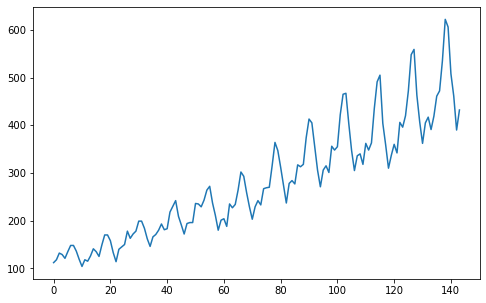

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(data['#Passengers']);

**Train Test Split**

In [6]:
X = data['#Passengers'].copy()
X_train = X[:120].copy()
X_test = X[120:].copy()

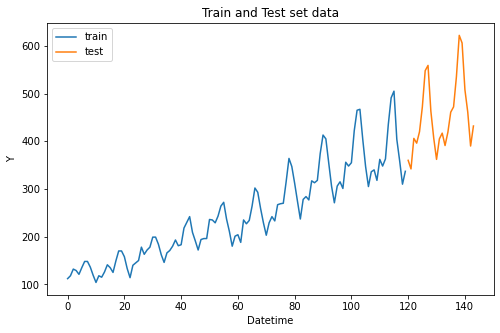

In [7]:
plt.figure(figsize=(8,5))
plt.plot(X_train,label='train')
plt.plot(X_test,label='test')
plt.legend()
plt.title("Train and Test set data")
plt.xlabel("Datetime")
plt.ylabel("Y")
plt.show()

**Exploring Stationarity**

It is clear that the timeseries has a trend (which can be visualized using a moving average) and seasonality.

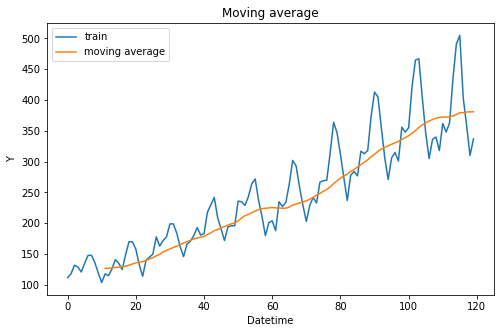

In [23]:
plt.figure(figsize=(8,5))
plt.plot(X_train, label='train')
plt.plot(X_train.rolling(window=12).mean(),label='moving average')
plt.legend()
plt.title("Moving average")
plt.xlabel("Datetime")
plt.ylabel("Y")
plt.show()

The timeseries also has a changing variance which can be visualized in the 1st difference and rolling standard deviation plots below.

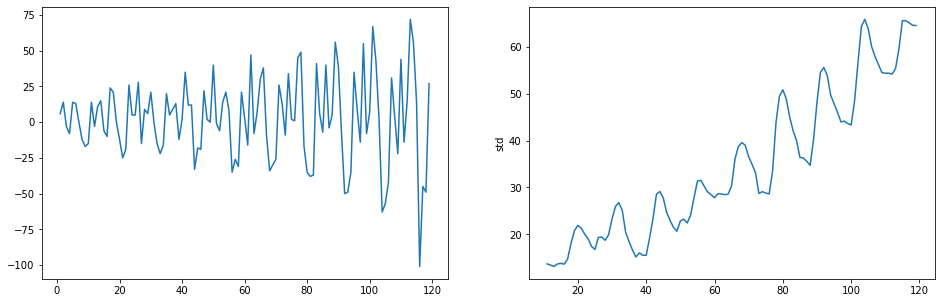

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax1.plot(X_train.diff())
ax2.plot(X_train.rolling(window=12).std())
ax2.set_ylabel("1st difference")
ax2.set_ylabel("std")
plt.show()

The series is therefore, non-stationary. While it is obvious for this series, it is a good idea to use a test to test for stationarity like the Augmented Dickey-Fuller test. The null hypothesis is that the series is non-stationary.

In [8]:
adfuller(X_train)

(-0.7734607708969401,
 0.8267937485032442,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 788.3190093041055)

## SARIMA

I will use a SARIMA model since the series has seasonality.

In [9]:
sarima_model = pm.auto_arima(
    X_train,
    start_p=2,
    d=None,
    start_q=2,
    seasonal=True,
    m=12,
    start_P=2,
    D=None,
    start_Q=1,
    alpha=0.05,
    test='adf',
    n_jobs=1,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    )

print(sarima_model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(2,1,1,12) [intercept=True]; AIC=806.965, BIC=831.021, Time=3.230 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=809.654, BIC=815.000, Time=0.010 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=806.973, BIC=817.664, Time=0.180 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=807.408, BIC=818.099, Time=0.160 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=807.655, BIC=810.327, Time=0.009 seconds
Fit ARIMA(2,1,2)x(1,1,1,12) [intercept=True]; AIC=809.204, BIC=830.587, Time=1.021 seconds
Near non-invertible roots for order (2, 1, 2)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(2,1,2)x(2,1,0,12) [intercept=True]; AIC=808.470, BIC=829.852, Time=2.650 seconds
Near non-invertible roots for order (2, 1, 2)(2, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
F

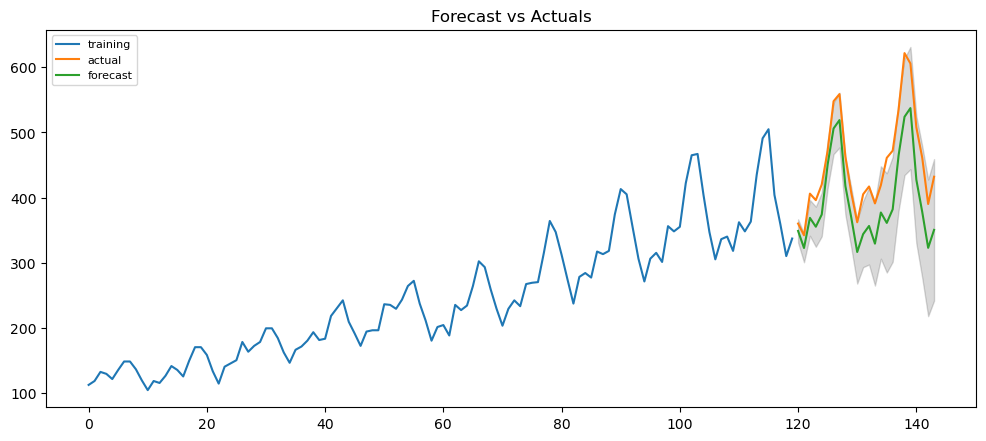

In [40]:
# Forecast
fc, conf = sarima_model.predict(n_periods=len(X_test), return_conf_int=True, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series    = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf[:, 0], index=X_test.index)
upper_series = pd.Series(conf[:, 1], index=X_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
print('RMSE:', np.round(mean_squared_error(X_test, fc_series.values, squared=False),2))

RMSE: 61.25


## Log Transformation

We can see that the variance of the time series is changing so I will try a log transformation.

In [13]:
X_log = np.log(data['#Passengers']).copy()
X_train_log = X_log[:120].copy()
X_test_log = X_log[120:].copy()

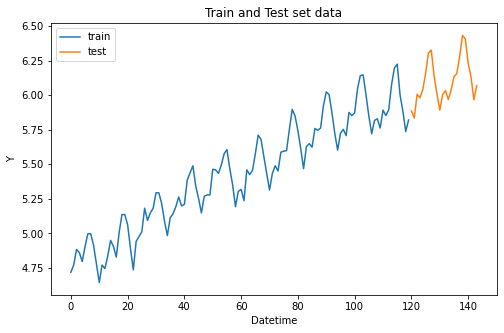

In [14]:
plt.figure(figsize=(8,5))
plt.plot(X_train_log,label='train')
plt.plot(X_test_log,label='test')
plt.legend()
plt.title("Train and Test set data")
plt.xlabel("Datetime")
plt.ylabel("Y")
plt.show()

In [15]:
sarima_model_log = pm.auto_arima(
    X_train_log,
    start_p=2,
    d=None,
    start_q=2,
    seasonal=True,
    m=12,
    start_P=2,
    D=None,
    start_Q=1,
    alpha=0.05,
    test='adf',
    n_jobs=1,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    )

print(sarima_model_log.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(2,1,1,12) [intercept=True]; AIC=-379.437, BIC=-355.382, Time=4.268 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=-351.414, BIC=-346.068, Time=0.018 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=-381.440, BIC=-370.749, Time=0.210 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=-387.202, BIC=-376.510, Time=0.533 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=-353.412, BIC=-350.739, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=-362.338, BIC=-354.319, Time=0.073 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=-385.423, BIC=-372.059, Time=0.647 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=-385.459, BIC=-372.095, Time=2.460 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=-382.352, BIC=-371.661, Time=0.293 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=-384.005, BIC=-367.968, Time=2.456 seconds
Near non-invertible roots 

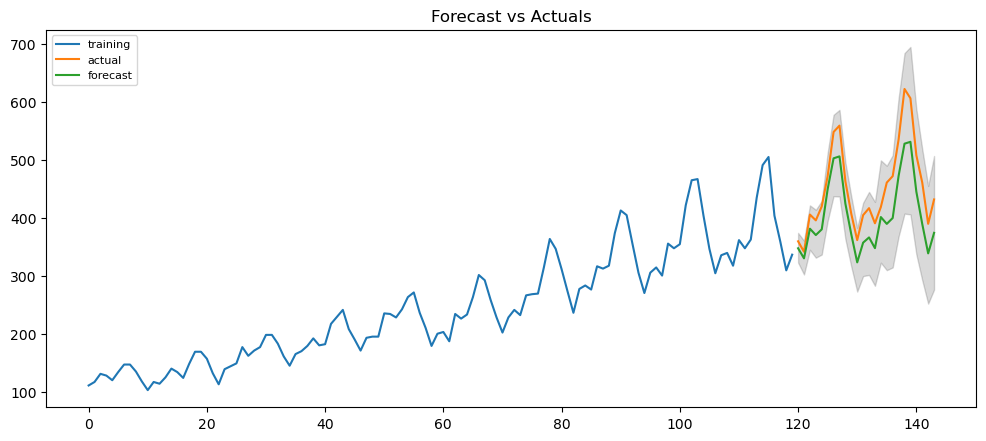

In [42]:
# Forecast
fc, conf = sarima_model_log.predict(n_periods=len(X_test_log), return_conf_int=True, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series    = pd.Series(np.exp(fc), index=X_test.index)
lower_series = pd.Series(np.exp(conf[:, 0]), index=X_test.index)
upper_series = pd.Series(np.exp(conf[:, 1]), index=X_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [43]:
print('RMSE:', np.round(mean_squared_error(X_test, fc_series.values, squared=False),2))

RMSE: 51.22


The log transformation improves the RMSE of the predictions.

In [99]:
prediction_period=48
new_index = pd.RangeIndex(start=X_test.index.stop, stop=X_test.index.stop+prediction_period)
model = pm.arima.ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model.fit(X_log)
pred = pd.Series(np.exp(model.predict(n_periods=prediction_period)), index=new_index)

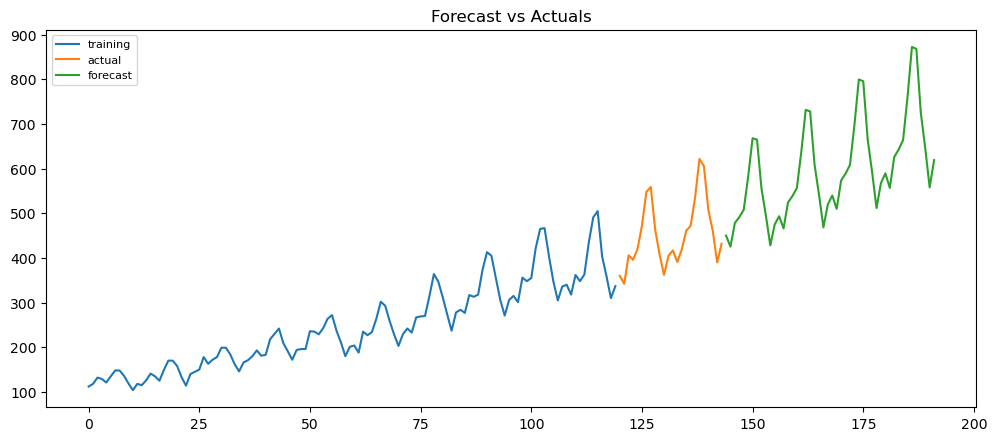

In [101]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train, label='training')
plt.plot(X_test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()